In [2]:
from __future__ import absolute_import, division, print_function
import base64
import IPython
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tf_agents.agents.dqn import dqn_agent
from tf_agents.drivers import dynamic_step_driver
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.networks import q_network
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.trajectories import trajectory
from tf_agents.utils import common

In [3]:
env = suite_gym.load('CartPole-v1')
env = tf_py_environment.TFPyEnvironment(env)

In [5]:
env.action_spec()

BoundedTensorSpec(shape=(), dtype=tf.int64, name='action', minimum=array(0), maximum=array(1))

In [3]:
q_net = q_network.QNetwork(env.observation_spec(), 
                           env.action_spec())

In [4]:
optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=0.001)

In [5]:
train_step_counter = tf.Variable(0)
agent = dqn_agent.DqnAgent(env.time_step_spec(),
                           env.action_spec(),
                           q_network=q_net,
                           optimizer=optimizer,
                           td_errors_loss_fn= 
                                  common.element_wise_squared_loss,
                           train_step_counter=train_step_counter)
agent.initialize()

Metal device set to: Apple M1


2022-02-22 23:49:08.741302: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-02-22 23:49:08.741600: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [6]:
def compute_avg_return(environment, policy, num_episodes=10):
    total_return = 0.0
    for _ in range(num_episodes):
        time_step = environment.reset()
        episode_return = 0.0
        while not time_step.is_last():
            action_step = policy.action(time_step)
            time_step = environment.step(action_step.action)
            episode_return += time_step.reward
        total_return += episode_return
    avg_return = total_return / num_episodes
    return avg_return.numpy()[0]
# Evaluate the agent's policy once before training.
avg_return = compute_avg_return(env, agent.policy, 5)
returns = [avg_return]

In [7]:
replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
                                data_spec=agent.collect_data_spec,                                                                
                                batch_size=env.batch_size,                                                              
                                max_length=100000)
def collect_step(environment, policy, buffer):
    time_step = environment.current_time_step()
    action_step = policy.action(time_step)
    next_time_step = environment.step(action_step.action)
    traj = trajectory.from_transition(time_step, 
                                      action_step, 
                                      next_time_step)
# Add trajectory to the replay buffer
    buffer.add_batch(traj)

In [8]:
collect_steps_per_iteration = 1
batch_size = 64
dataset = replay_buffer.as_dataset(num_parallel_calls=3, 
                                   sample_batch_size=batch_size, 
                                   num_steps=2).prefetch(3)
iterator = iter(dataset)
num_iterations = 20000
env.reset()
for _ in range(batch_size):
    collect_step(env, agent.policy, replay_buffer)
for _ in range(num_iterations):
    # Collect a few steps using collect_policy and save to the replay buffer.
    for _ in range(collect_steps_per_iteration):
        collect_step(env, agent.collect_policy, replay_buffer)
    # Sample a batch of data from the buffer and update the agent's network.
    experience, unused_info = next(iterator)
    train_loss = agent.train(experience).loss
    step = agent.train_step_counter.numpy()
    # Print loss every 200 steps.
    if step % 200 == 0:
        print('step = {0}: loss = {1}'.format(step, train_loss))
    # Evaluate agent's performance every 1000 steps.
    if step % 1000 == 0:
        avg_return = compute_avg_return(env, agent.policy, 5)
        print('step = {0}: Average Return = {1}'.format(step, avg_return))
        returns.append(avg_return)

Instructions for updating:
Use `as_dataset(..., single_deterministic_pass=False) instead.


2022-02-22 23:50:14.438120: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.foldr(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.foldr(fn, elems))
step = 200: loss = 53.32616424560547
step = 400: loss = 21.46654510498047
step = 600: loss = 20.30841064453125
step = 800: loss = 74.71954345703125
step = 1000: loss = 20.800962448120117
step = 1000: Average Return = 41.60000228881836
step = 1200: loss = 189.23214721679688
step = 1400: loss = 54.75939178466797
step = 1600: loss = 30.99264144897461
step = 1800: loss = 90.02296447753906
step = 2000: loss = 129.39886474609375
step = 2000: Average Return = 326.8000183105469
step = 2200: loss = 249.5363006591797
step = 2400: loss = 220.77713012695312
step = 2600: loss = 1491.1597900390625
step = 2800: loss = 348.8177795410156
step = 3000: loss = 328.7870178222656
step = 3000: Average Return = 299.8000183105469
step = 3200: loss = 145.3824005126953
step = 3400: 

/Users/noahrowe/miniforge3/lib/python3.9/site-packages/tf_agents/utils/common.py:1432: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  return state is not None and state is not () and state is not []
/Users/noahrowe/miniforge3/lib/python3.9/site-packages/tf_agents/utils/common.py:1432: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  return state is not None and state is not () and state is not []


KeyboardInterrupt: 

Text(0.5, 0, 'Iterations')

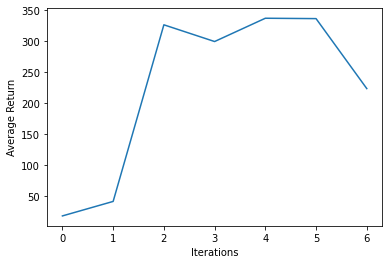

In [13]:
iterations = range(0, num_iterations + 1, 1000)
plt.plot(returns)
plt.ylabel('Average Return')
plt.xlabel('Iterations')

In [15]:
def embed_mp4(filename):
    """Embeds an mp4 file in the notebook."""
    video = open(filename,'rb').read()
    b64 = base64.b64encode(video)
    tag = '''
    <video width="640" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
    Your browser does not support the video tag.
    </video>'''.format(b64.decode())

    return IPython.display.HTML(tag)

In [35]:
def create_policy_eval_video(policy, filename, num_episodes=5, fps=30):
    filename = filename + ".mp4"
    with imageio.get_writer(filename, fps=fps) as video:
        for _ in range(num_episodes):
            time_step = env.reset()
            video.append_data(np.squeeze(env.render().numpy()))
            while not time_step.is_last():
                action_step = policy.action(time_step)
                time_step = env.step(action_step.action)
                video.append_data(np.squeeze(env.render().numpy()))
    return embed_mp4(filename)

create_policy_eval_video(agent.policy, "trained-agent")

[swscaler @ 0x7fdb98008000] Warning: data is not aligned! This can lead to a speedloss


In [41]:
# Try it random
from tf_agents.policies import random_tf_policy
random_policy = random_tf_policy.RandomTFPolicy(env.time_step_spec(),
                                                env.action_spec())

num_eval_episodes = 100
compute_avg_return(env, random_policy, num_eval_episodes)

20.71

In [20]:
imageio.plugins.ffmpeg.download()

Imageio: 'ffmpeg-osx-v3.2.4' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg-osx-v3.2.4 (33.8 MB)
Downloading: 8192/35458856 bytes (0.0376832/35458856 bytes (1.12752512/35458856 bytes (7.8%7921664/35458856 bytes (22.313369344/35458856 bytes (37.7%18817024/35458856 bytes (53.1%24264704/35458856 bytes (68.4%29720576/35458856 bytes (83.8%35192832/35458856 bytes (99.2%35458856/35458856 bytes (100.0%)
  Done
File saved as /Users/noahrowe/Library/Application Support/imageio/ffmpeg/ffmpeg-osx-v3.2.4.
